In [1]:
from dolfinx import default_scalar_type, plot
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, assemble_scalar,
                         form, locate_dofs_geometrical, locate_dofs_topological, Expression)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import create_unit_square, locate_entities
from dolfinx.plot import vtk_mesh

from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner)

from mpi4py import MPI

import meshio
import gmsh
import numpy as np
import pyvista
import math
import ufl
from dolfinx.io import XDMFFile
from dolfinx.mesh import meshtags_from_entities
from dolfinx.cpp.mesh import cell_entity_type
from dolfinx.io import distribute_entity_data
from dolfinx.graph import adjacencylist
from dolfinx.mesh import create_mesh
from dolfinx.cpp.mesh import to_type
from dolfinx.cpp.io import perm_gmsh
import numpy
from dolfinx.io import gmshio
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh
import numpy as np
import gmsh
import warnings
import random
warnings.filterwarnings("ignore")
import pyvista as pv

In [2]:
rho = 0
g = 9.81
dimension = 3 # Dimension. Should not be modified
L = 1 # Side length of unit cell

volume_fraction = 0.2  # Target volume fraction
num_particles = 5
r = ((volume_fraction*3*np.sqrt(np.pi)/4)/(num_particles*np.pi**(dimension/2)))**(1/dimension)
print(f"r: {r}")

mu_particle = 0.001
mu_matrix = 10
kappa = 0

traction = -0.02

delDistanceMultiplier = 1.2 # Multiplier for distance between the centers of particles
delDistanceBorder = L*0.02 # Min distance of center of particles from borders

resolution_minRadiusMultiplier = 1/2 # Mesh resolution multiplier of the min radius
LcMin_resoMultiplier = 0.25 # Min cell size multiplier of the resolution
LcMax_resoMultiplier = 1 # Max ...
DistMin_resoMultiplier = 0.15 # Min distance of effect multiplier of resolution
DistMax_resoMultiplier = 1 # Max ...

r: 0.21215688358941107


In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def is_overlapping(particle, particles):
    for p in particles:
        if distance(p[0], particle[0]) < (p[1] + particle[1]) * delDistanceMultiplier:
            return True
    return False

def intersects_corner(particle):
    x, y, z = particle[0]
    r = particle[1]
    corners = [(0, 0, 0), (0, 0, L), (0, L, 0), (0, L, L), (L, 0, 0), (L, 0, L), (L, L, 0), (L, L, L)]
    for corner in corners:
        if distance((x, y, z), corner) <= r:
            return True
    return False

def intersects_edge(particle):
    x, y, z = particle[0]
    r = particle[1]
    edges = [
        ((0, 0, 0), (L, 0, 0)), ((0, 0, 0), (0, L, 0)), ((0, 0, 0), (0, 0, L)),
        ((0, L, 0), (L, L, 0)), ((0, L, 0), (0, L, L)), ((L, 0, 0), (L, L, 0)),
        ((L, 0, 0), (L, 0, L)), ((0, 0, L), (L, 0, L)), ((0, 0, L), (0, L, L)),
        ((0, L, L), (L, L, L)), ((L, 0, L), (L, L, L)), ((L, L, 0), (L, L, L))
    ]
    for edge in edges:
        for i in range(3):
            if edge[0][i]-edge[1][i]!=0:
                axes=i
        midpoint = tuple((c1 + c2) / 2 for c1, c2 in zip(edge[0], edge[1]))
        midpoint[i]==particle[0][i]
        theDist = distance((x,y,z),midpoint)
        if theDist <= r:
            return True
    return False

def intersects_face(particle):
    x, y, z = particle[0]
    r = particle[1]
    faces = [
        (x, 0, z), (x, L, z), (x, y, 0), (x, y, L), (0, y, z), (L, y, z)
    ]
    for face in faces:
        if distance((x, y, z), face) <= r:
            return True
    return False

def intersects_allBoundary(particle):
    corner = intersects_corner(particle)
    if corner:
        return True, ['corner']
    
    edge = intersects_edge(particle)
    if edge:
        return True, ['edge']
    
    face = intersects_face(particle)
    if face:
        return True, ['face']
    
    return False, []

def closest_corner(center):
    # Get the closest corner to the given center
    corner_coords = [
        (0, 0, 0), (0, 0, L), (0, L, 0), (0, L, L),
        (L, 0, 0), (L, 0, L), (L, L, 0), (L, L, L)
    ]
    closest_corner = min(corner_coords, key=lambda c: distance(center, c))
    return closest_corner

def reproduce_in_corners(particle):
    # Get the center and radius of the given particle
    center, radius = particle
    
    # Find the closest corner to the particle's center
    reference_corner = closest_corner(center)
    
    # Compute the displacement vector from the closest corner to the origin
    origin_displacement = (-reference_corner[0], -reference_corner[1], -reference_corner[2])
    
    # Get the coordinates of all eight corners of the unit cell
    corners = [
        (0, 0, 0), (0, 0, L), (0, L, 0), (0, L, L),
        (L, 0, 0), (L, 0, L), (L, L, 0), (L, L, L)
    ]
    
    # Reproduce the particle at each corner considering the closest corner
    reproduced_particles = [((x + center[0] + origin_displacement[0], 
                              y + center[1] + origin_displacement[1], 
                              z + center[2] + origin_displacement[2]), radius) for x, y, z in corners]
    return reproduced_particles

def closest_edge(center):
    # Define all edges as pairs of points
    edges = [
        ((0, 0, 0), (L, 0, 0)), ((0, 0, 0), (0, L, 0)), ((0, 0, 0), (0, 0, L)),
        ((0, L, 0), (L, L, 0)), ((0, L, 0), (0, L, L)), ((L, 0, 0), (L, L, 0)),
        ((L, 0, 0), (L, 0, L)), ((0, 0, L), (L, 0, L)), ((0, 0, L), (0, L, L)),
        ((0, L, L), (L, L, L)), ((L, 0, L), (L, L, L)), ((L, L, 0), (L, L, L))
    ]
    
    # Find the closest edge to the center
    min_distance = float('inf')
    closest_edge = None
    for edge in edges:
        midpoint = tuple((c1 + c2) / 2 for c1, c2 in zip(edge[0], edge[1]))
        d = distance(center, midpoint)
        if d < min_distance:
            min_distance = d
            closest_edge = edge
    return closest_edge

def reproduce_in_edges(particle):
    # Get the center and radius of the given particle
    center, radius = particle
    
    # Find the closest edge to the particle's center
    reference_edge = closest_edge(center)
    
    # Determine the direction of the reference edge
    direction = tuple(b - a for a, b in zip(*reference_edge))
    
    # Define all edges as pairs of points
    edges = [
        ((0, 0, 0), (L, 0, 0)), ((0, 0, 0), (0, L, 0)), ((0, 0, 0), (0, 0, L)),
        ((0, L, 0), (L, L, 0)), ((0, L, 0), (0, L, L)), ((L, 0, 0), (L, L, 0)),
        ((L, 0, 0), (L, 0, L)), ((0, 0, L), (L, 0, L)), ((0, 0, L), (0, L, L)),
        ((0, L, L), (L, L, L)), ((L, 0, L), (L, L, L)), ((L, L, 0), (L, L, L))
    ]
    
    # Filter the edges to find those parallel to the reference edge
    parallel_edges = [edge for edge in edges if tuple(b - a for a, b in zip(*edge)) == direction]
    
    # Compute the displacement vector from the reference edge's midpoint to the origin
    midpoint = tuple((c1 + c2) / 2 for c1, c2 in zip(reference_edge[0], reference_edge[1]))
    origin_displacement = (-midpoint[0], -midpoint[1], -midpoint[2])
    
    # Reproduce the particle at the midpoint of each parallel edge considering the reference edge's displacement
    reproduced_particles = [((0.5 * (edge[0][0] + edge[1][0]) + center[0] + origin_displacement[0],
                              0.5 * (edge[0][1] + edge[1][1]) + center[1] + origin_displacement[1],
                              0.5 * (edge[0][2] + edge[1][2]) + center[2] + origin_displacement[2]), radius) for edge in parallel_edges]
    return reproduced_particles

def closest_face(center):
    # Define the center of each face of the unit cell
    faces = [
        (L / 2, 0, L / 2), (L / 2, L, L / 2), (L / 2, L / 2, 0),
        (L / 2, L / 2, L), (0, L / 2, L / 2), (L, L / 2, L / 2)
    ]
    
    # Find the closest face center to the particle's center
    closest_face_center = min(faces, key=lambda face: distance(center, face))
    return closest_face_center

def reproduce_in_faces(particle):
    # Get the center and radius of the given particle
    center, radius = particle
    
    # Find the closest face center to the particle's center
    reference_face_center = closest_face(center)
    
    # Compute the displacement vector from the closest face center to the origin
    origin_displacement = (-reference_face_center[0], -reference_face_center[1], -reference_face_center[2])
    
    # Define the center of each face of the unit cell
    faces = [
        (L / 2, 0, L / 2), (L / 2, L, L / 2), (L / 2, L / 2, 0),
        (L / 2, L / 2, L), (0, L / 2, L / 2), (L, L / 2, L / 2)
    ]
    
    # Determine the normal of the reference face
    normal = tuple(fc - oc for fc, oc in zip(reference_face_center, (L/2, L/2, L/2)))
    for element in normal:
        if element != 0:
            axis = normal.index(element)
            print(f"axis found: {axis}")
    
    parallel_faces_normal = [0,0,0]
    parallel_faces_normal[axis]-=normal[axis]
    parallel_faces_normal = tuple(parallel_faces_normal)
    print(f"parallel_faces_normal: {parallel_faces_normal}")

    # Filter the faces to find those parallel to the reference face
    parallel_faces = [face for face in faces if tuple(fc - oc for fc, oc in zip(face, (L/2, L/2, L/2))) == parallel_faces_normal]
    
    # Reproduce the particle at the center of each parallel face considering the reference face center's displacement
    reproduced_particles = [((face[0] + center[0] + origin_displacement[0],
                              face[1] + center[1] + origin_displacement[1],
                              face[2] + center[2] + origin_displacement[2]), radius) for face in parallel_faces]
    return reproduced_particles

def sphere_volume_in_face(particle):
    center,radius=particle
    def sphere_cap_volume(h, r):
        return (math.pi * h**2 * (3*r - h)) / 3
    
    x, y, z = center
    full_volume = (4/3) * math.pi * radius**3

    # Check intersection with each face of the cube and subtract the corresponding cap volume if necessary
    intersection_volume = full_volume

    # Faces at x = 0 and x = L
    if x - radius < 0:
        cap_height = radius - x
        intersection_volume -= sphere_cap_volume(cap_height, radius)
    if x + radius > L:
        cap_height = radius - (L - x)
        intersection_volume -= sphere_cap_volume(cap_height, radius)

    # Faces at y = 0 and y = L
    if y - radius < 0:
        cap_height = radius - y
        intersection_volume -= sphere_cap_volume(cap_height, radius)
    if y + radius > L:
        cap_height = radius - (L - y)
        intersection_volume -= sphere_cap_volume(cap_height, radius)

    # Faces at z = 0 and z = L
    if z - radius < 0:
        cap_height = radius - z
        intersection_volume -= sphere_cap_volume(cap_height, radius)
    if z + radius > L:
        cap_height = radius - (L - z)
        intersection_volume -= sphere_cap_volume(cap_height, radius)

    return max(intersection_volume, 0)

def sphere_volume_in_corner(particle):
    center,radius=particle
    x, y, z = center
    if x - radius < 0 and y - radius < 0 and z - radius < 0:
        return (1/8) * (4/3) * math.pi * radius**3
    if x + radius > L and y - radius < 0 and z - radius < 0:
        return (1/8) * (4/3) * math.pi * radius**3
    if x - radius < 0 and y + radius > L and z - radius < 0:
        return (1/8) * (4/3) * math.pi * radius**3
    if x - radius < 0 and y - radius < 0 and z + radius > L:
        return (1/8) * (4/3) * math.pi * radius**3
    if x + radius > L and y + radius > L and z - radius < 0:
        return (1/8) * (4/3) * math.pi * radius**3
    if x + radius > L and y - radius < 0 and z + radius > L:
        return (1/8) * (4/3) * math.pi * radius**3
    if x - radius < 0 and y + radius > L and z + radius > L:
        return (1/8) * (4/3) * math.pi * radius**3
    if x + radius > L and y + radius > L and z + radius > L:
        return (1/8) * (4/3) * math.pi * radius**3
    return 0

def sphere_volume_in_edge(particle):
    center,radius=particle
    def sphere_cap_volume(h, r):
        return (math.pi * h**2 * (3*r - h)) / 3
    
    x, y, z = center
    full_volume = (4/3) * math.pi * radius**3

    # Check intersection with each face of the cube and subtract the corresponding cap volume if necessary
    intersection_volume = full_volume

    # Edges at x = 0, L; y = 0, L; z = 0, L
    if (x - radius < 0 and y - radius < 0) or (x - radius < 0 and z - radius < 0) or (y - radius < 0 and z - radius < 0):
        cap_height = radius - min(x, y, z)
        intersection_volume -= (1/4) * sphere_cap_volume(cap_height, radius)
    if (x + radius > L and y + radius > L) or (x + radius > L and z + radius > L) or (y + radius > L and z + radius > L):
        cap_height = radius - (L - max(x, y, z))
        intersection_volume -= (1/4) * sphere_cap_volume(cap_height, radius)
    if (x - radius < 0 and y + radius > L) or (x - radius < 0 and z + radius > L) or (y - radius < 0 and z + radius > L):
        cap_height = radius - min(x, L - y, z)
        intersection_volume -= (1/4) * sphere_cap_volume(cap_height, radius)
    if (x + radius > L and y - radius < 0) or (x + radius > L and z - radius < 0) or (y + radius > L and z - radius < 0):
        cap_height = radius - min(L - x, y, z)
        intersection_volume -= (1/4) * sphere_cap_volume(cap_height, radius)

    return max(intersection_volume, 0)

def generate_particles(volume_fraction, num_particles, max_iterations=10**8):
    particles = []
    num = 0
    totalVolume = 0
    while num <= num_particles:
        radius = r
        center = (random.uniform(0 + delDistanceBorder, 1 - delDistanceBorder), random.uniform(0 + delDistanceBorder, 1 - delDistanceBorder), random.uniform(0 + delDistanceBorder, 1 - delDistanceBorder))
        particle = (center, radius)
        if not is_overlapping(particle, particles): # and particle[1]<=rMax and particle[1]>=rMin:
            isBoundary, modes = intersects_allBoundary(particle)
            if isBoundary:
                if modes[0] == "corner":
                    reproduced = reproduce_in_corners(particle)
                    check = 0
                    reproVolume = 0
                    for part in reproduced:
                        if not is_overlapping(part, particles):
                            check += 1
                            reproVolume+=sphere_volume_in_corner(part)
                    if check == len(reproduced) and len(reproduced)<=num_particles-num and totalVolume + reproVolume + sphere_volume_in_edge(particle)<=L**3*volume_fraction:
                        particles.append(particle)
                        num += 1
                        print(f"og part: {particle}")
                        for part in reproduced:
                            particles.append(part)
                            num += 1
                            print(f"reproduced part: {part}")

                elif modes[0] == "edge":
                    reproduced = reproduce_in_edges(particle)
                    check = 0
                    reproVolume = 0
                    for part in reproduced:
                        if not is_overlapping(part, particles):
                            check += 1
                            reproVolume+=sphere_volume_in_edge(part)
                    if check == len(reproduced) and len(reproduced)<=num_particles-num and totalVolume + reproVolume + sphere_volume_in_edge(particle)<=L**3*volume_fraction:
                        particles.append(particle)
                        num += 1
                        print(f"og part: {particle}")
                        for part in reproduced:
                            particles.append(part)
                            num += 1
                            print(f"reproduced part: {part}")
                    
                elif modes[0] == "face":
                    reproduced = reproduce_in_faces(particle)
                    check = 0
                    reproVolume = 0
                    for part in reproduced:
                        if not is_overlapping(part, particles):
                            check += 1
                            reproVolume+=sphere_volume_in_face(part)
                    if check == len(reproduced) and len(reproduced)<=num_particles-num and totalVolume + reproVolume + sphere_volume_in_face(particle)<=L**3*volume_fraction:
                        particles.append(particle)
                        num += 1
                        print(f"og part: {particle}")
                        for part in reproduced:
                            particles.append(part)
                            num += 1
                            print(f"reproduced part: {part}")

            elif not isBoundary:
                if totalVolume+4/3*np.pi*r**3<=volume_fraction:
                    totalVolume+=4/3*np.pi*r**3
                    particles.append(particle)
                    num += 1
                    print(f"direct particle: {particle}")
    return particles

# Example usage:
particles = generate_particles(volume_fraction, num_particles)

# Print the generated particles
centerCoordinatesList = [center for center, radius in particles]
radiusList = [radius for center, radius in particles]
print(f"Center: {centerCoordinatesList}")
print(f"radii: {radiusList}")

axis found: 1
parallel_faces_normal: (0, 0.5, 0)
og part: ((0.7194114287524187, 0.13957595125440012, 0.35162456641373446), 0.21215688358941107)
reproduced part: ((0.7194114287524187, 1.1395759512544001, 0.3516245664137345), 0.21215688358941107)
direct particle: ((0.7359635966580417, 0.47892355661237807, 0.7810539753890866), 0.21215688358941107)
axis found: 0
parallel_faces_normal: (0.5, 0, 0)
axis found: 2
parallel_faces_normal: (0, 0, -0.5)
og part: ((0.2194036239073272, 0.5842291945284187, 0.8576029245328254), 0.21215688358941107)
reproduced part: ((0.21940362390732715, 0.5842291945284188, -0.14239707546717462), 0.21215688358941107)
axis found: 0
parallel_faces_normal: (-0.5, 0, 0)
axis found: 0
parallel_faces_normal: (0.5, 0, 0)
axis found: 2
parallel_faces_normal: (0, 0, 0.5)
axis found: 0
parallel_faces_normal: (0.5, 0, 0)
axis found: 1
parallel_faces_normal: (0, 0.5, 0)
axis found: 0
parallel_faces_normal: (-0.5, 0, 0)
axis found: 2
parallel_faces_normal: (0, 0, -0.5)
direct part

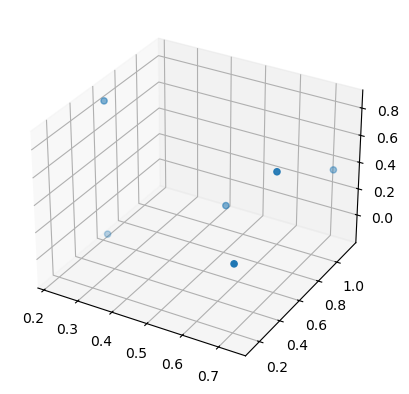

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming centerCoordinatesList is a list of tuples or lists with 3D coordinates, e.g., [(x1, y1, z1), (x2, y2, z2), ...]

# Extract x, y, and z coordinates using list comprehensions
x = [center[0] for center in centerCoordinatesList]
y = [center[1] for center in centerCoordinatesList]
z = [center[2] for center in centerCoordinatesList]

# Create a new figure for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot
ax.scatter(x, y, z)

# Show the plot
plt.show()


In [5]:
gmsh.initialize()

In [6]:
surfTag = []
gmsh.model.add("DFG 3D")
for center,radius in particles:
    sphereTag = gmsh.model.occ.addSphere(center[0], center[1], center[2], radius, tag=2)
    gmsh.model.occ.synchronize()
    surface_entities = gmsh.model.get_entities(dim=2)
    surfTag.append(surface_entities)
    gmsh.model.occ.remove([(3, 2)])
    gmsh.model.occ.synchronize()

surfTag=surfTag[-1]
print(surfTag)

[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]


In [7]:
cube = gmsh.model.occ.addBox(0, 0, 0, L, L, L, tag=1)
gmsh.model.occ.synchronize()

fragments = gmsh.model.occ.fragment([(3,cube)],surfTag,removeTool=False,removeObject=True)
gmsh.model.occ.synchronize()

volumeDimTags = []
volumeDimTags.append(gmsh.model.get_entities(dim=3))

physicalTags = []
i=0
for dim,tag in volumeDimTags[0]:
    gmsh.model.addPhysicalGroup(3, [tag], tag=420+i)
    physicalTags.append(420+i)
    i+=1

In [8]:
distance = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(distance, "FacesList", [surfTag[i][1] for i in range(len(radiusList))])

resolution = resolution_minRadiusMultiplier*r

# Configure the Threshold field
threshold = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(threshold, "IField", distance)
gmsh.model.mesh.field.setNumber(threshold, "LcMin", LcMin_resoMultiplier*resolution)  # Minimum element size
gmsh.model.mesh.field.setNumber(threshold, "LcMax", LcMax_resoMultiplier*resolution)  # Maximum element size
gmsh.model.mesh.field.setNumber(threshold, "DistMin", DistMin_resoMultiplier*resolution)  # Distance below which LcMin is applied
gmsh.model.mesh.field.setNumber(threshold, "DistMax", DistMax_resoMultiplier*resolution)  # Distance above which LcMax is applied

# 3. Combine fields to ensure the smallest element size is used
minimum = gmsh.model.mesh.field.add("Min")
gmsh.model.mesh.field.setNumbers(minimum, "FieldsList", [threshold])
gmsh.model.mesh.field.setAsBackgroundMesh(minimum)

In [9]:
#gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.001)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.1)
gmsh.model.mesh.generate(3)
gmsh.fltk.run()
gmsh.write("mesh2.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 20%] Meshing curve 5 (Circle)
Info    : [ 20%] Meshing curve 8 (Circle)
Info    : [ 30%] Meshing curve 11 (Circle)
Info    : [ 40%] Meshing curve 14 (Circle)
Info    : [ 50%] Meshing curve 17 (Circle)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 70%] Meshing curve 24 (Line)
Info    : [ 70%] Meshing curve 25 (Line)
Info    : [ 70%] Meshing curve 26 (Circle)
Info    : [ 70%] Meshing curve 27 (Line)
Info    : [ 80%] Meshing curve 28 (Line)
Info    : [ 80%] Meshing curve 29 (Circle)
Info    : [ 80%] Meshing curve 30 (Line)
Info    : [ 80%] Meshing curve 31 (Line)
Info    : [ 90%] Meshing curve 32 (Circle)
Info    : [ 90%] Meshing curve 33 (Line)
Info    : [ 90%] Meshing curve 34 (Circle)
Info    : [ 90%] Meshing curve 35 (Circle)
Info    : [100

In [10]:
def create_mesh(mesh, cell_type):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data.astype(np.int32)]})
    return out_mesh

In [11]:
msh = meshio.read("mesh2.msh")
triangle_mesh = create_mesh(msh, "tetra")
meshio.write("mesh.xdmf", triangle_mesh)
MPI.COMM_WORLD.barrier()

In [12]:
with XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

In [13]:
print([physicalTags[i] for i in range(1,len(physicalTags))])

[421, 422, 423, 424, 425, 426]


In [14]:
Q = functionspace(mesh, ("DG", 0))
mu = Function(Q)
print(physicalTags)
mtrx = ct.find(physicalTags[0])
mu.x.array[mtrx] = np.full_like(mtrx, mu_matrix, dtype=default_scalar_type)
ptcls=[]
for i in range(1,len(physicalTags)):
    ptcls.append(ct.find(physicalTags[i]))
for i in range(0,len(ptcls)):
    mu.x.array[ptcls[i]] = np.full_like(ptcls[i], mu_particle, dtype=default_scalar_type)

[420, 421, 422, 423, 424, 425, 426]


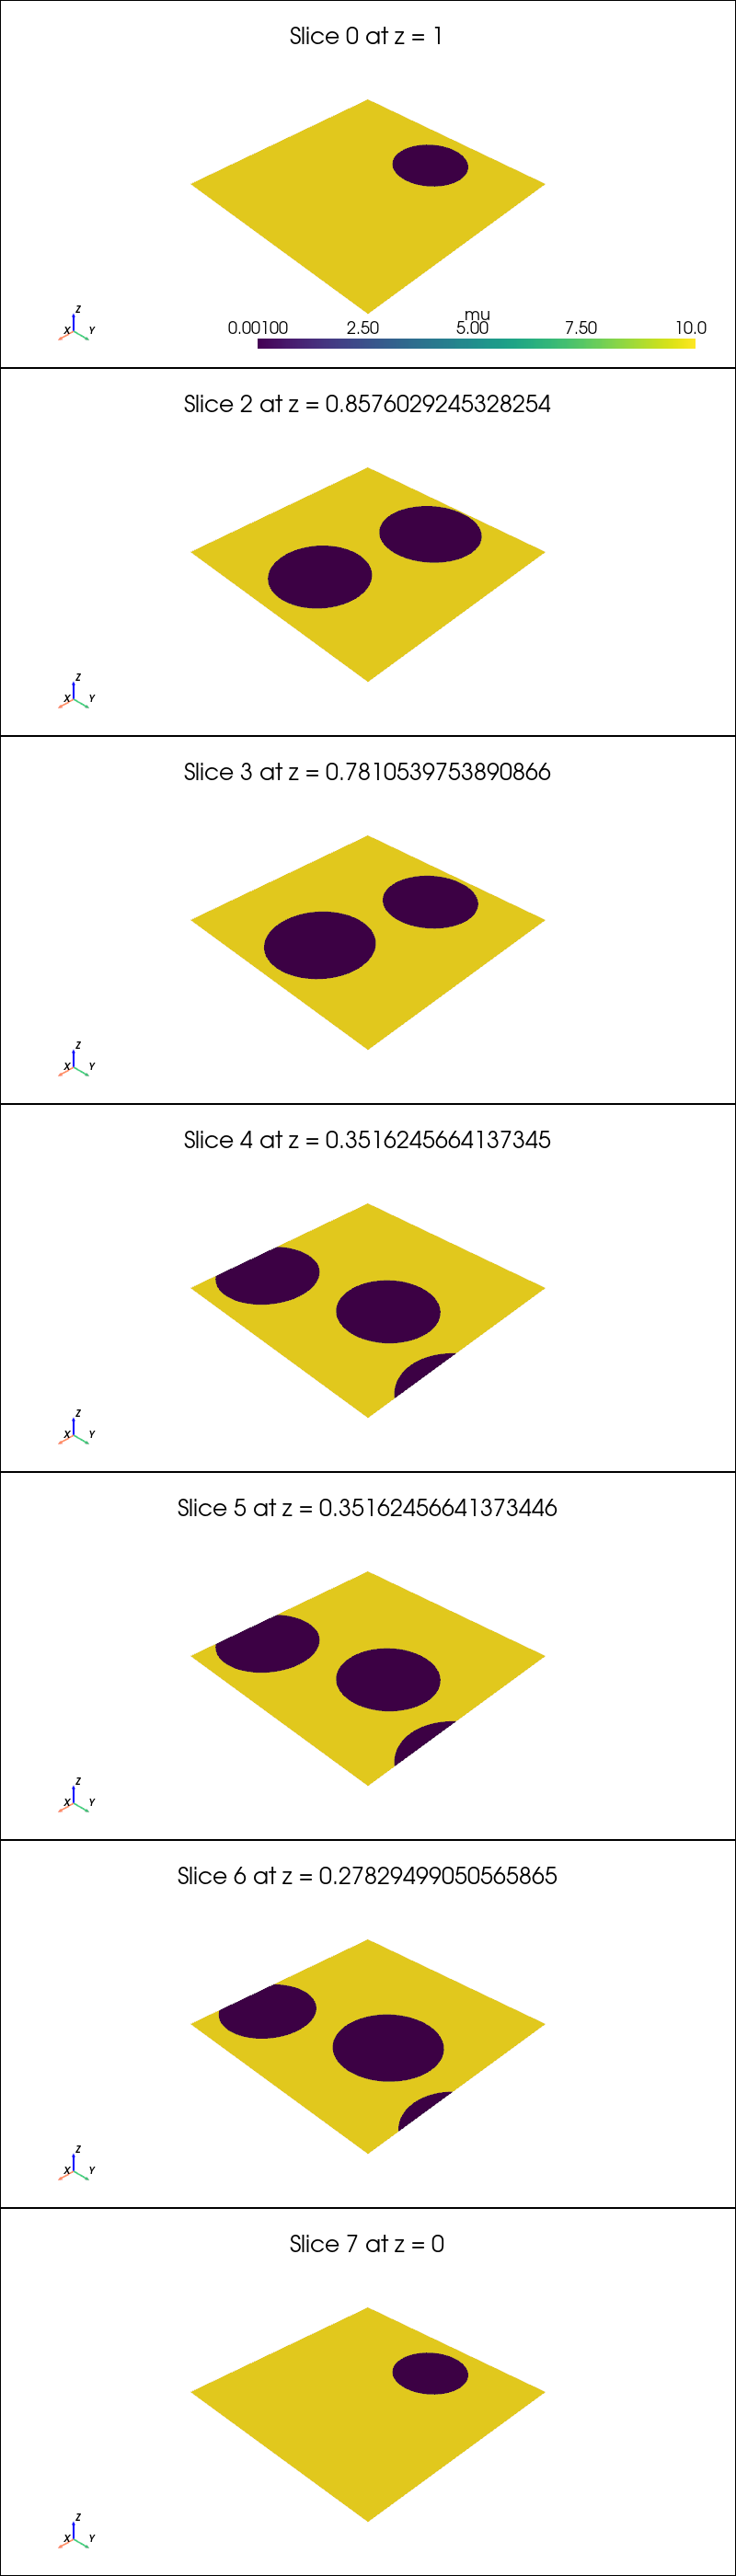

In [15]:
# Visualization using PyVista
pyvista.start_xvfb()
# Create a plotter with the number of subplots matching the number of particles
ParticleDatas = particles
particles.sort(key=lambda x: x[0][2], reverse=True)

outOfBounds = []
for center,radius in particles:
    if float(center[2])>float(L) or center[2]<0:
        outOfBounds.append(particles.index((center,radius)))

num_slices = len(particles) - len(outOfBounds)+2
p = pyvista.Plotter(shape=(num_slices, 1), window_size=[800, 400 * num_slices])
topology, cell_types, geometry = plot.vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach von Mises stress values to the grid
mu_values = mu.x.array
grid["mu"] = mu_values


p.subplot(0, 0)
slice_filter = grid.slice(normal='z', origin=(0,0,1-10**-10))
p.add_mesh(slice_filter, scalars="mu", cmap="viridis", show_edges=False, opacity=1)
p.add_title(f'Slice {0} at z = {1}', font_size=10)
p.show_axes()
i = 1
for center, radius in particles:
    if not particles.index((center,radius)) in outOfBounds:
        p.subplot(i, 0)
        slice_filter = grid.slice(normal='z', origin=center)
        p.add_mesh(slice_filter, scalars="mu", cmap="viridis", show_edges=False, opacity=1)
        z_coord = center[2]
        p.add_title(f'Slice {i+1} at z = {z_coord}', font_size=10)
        p.show_axes()
        i+=1
p.subplot(num_slices-1, 0)
slice_filter = grid.slice(normal='z', origin=(0,0,10**-10))
p.add_mesh(slice_filter, scalars="mu", cmap="viridis", show_edges=False, opacity=1)
p.add_title(f'Slice {num_slices} at z = {0}', font_size=10)
p.show_axes()

# Show the plot with all slices in subplots
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("mu.png")

In [16]:
V = functionspace(mesh, ("Lagrange",1,(mesh.geometry.dim, )))

num_rows = 5
side_length = 1
gap = 2 / 8 * side_length
dy = math.sqrt(3) * 1 * side_length + gap
frame_height = (num_rows - 1) * dy

def bottom_boundary(x):
    return np.isclose(x[1], 0)

boundary_dofs_bottom = locate_dofs_geometrical(V, bottom_boundary)

u_bottom = Function(V)
with u_bottom.vector.localForm() as loc:
    loc.set(0.0)

bc = dirichletbc(u_bottom, boundary_dofs_bottom)
T = Constant(mesh, default_scalar_type((0, traction, 0)))
ds = ufl.Measure("ds", domain=mesh)

def epsilon(u):
    return 1/2*(ufl.nabla_grad(u)+ufl.nabla_grad(u).T)  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return (kappa-2/3*mu) * ufl.nabla_div(u) * ufl.Identity(3) + 2 * mu * epsilon(u)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = Constant(mesh, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds 

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

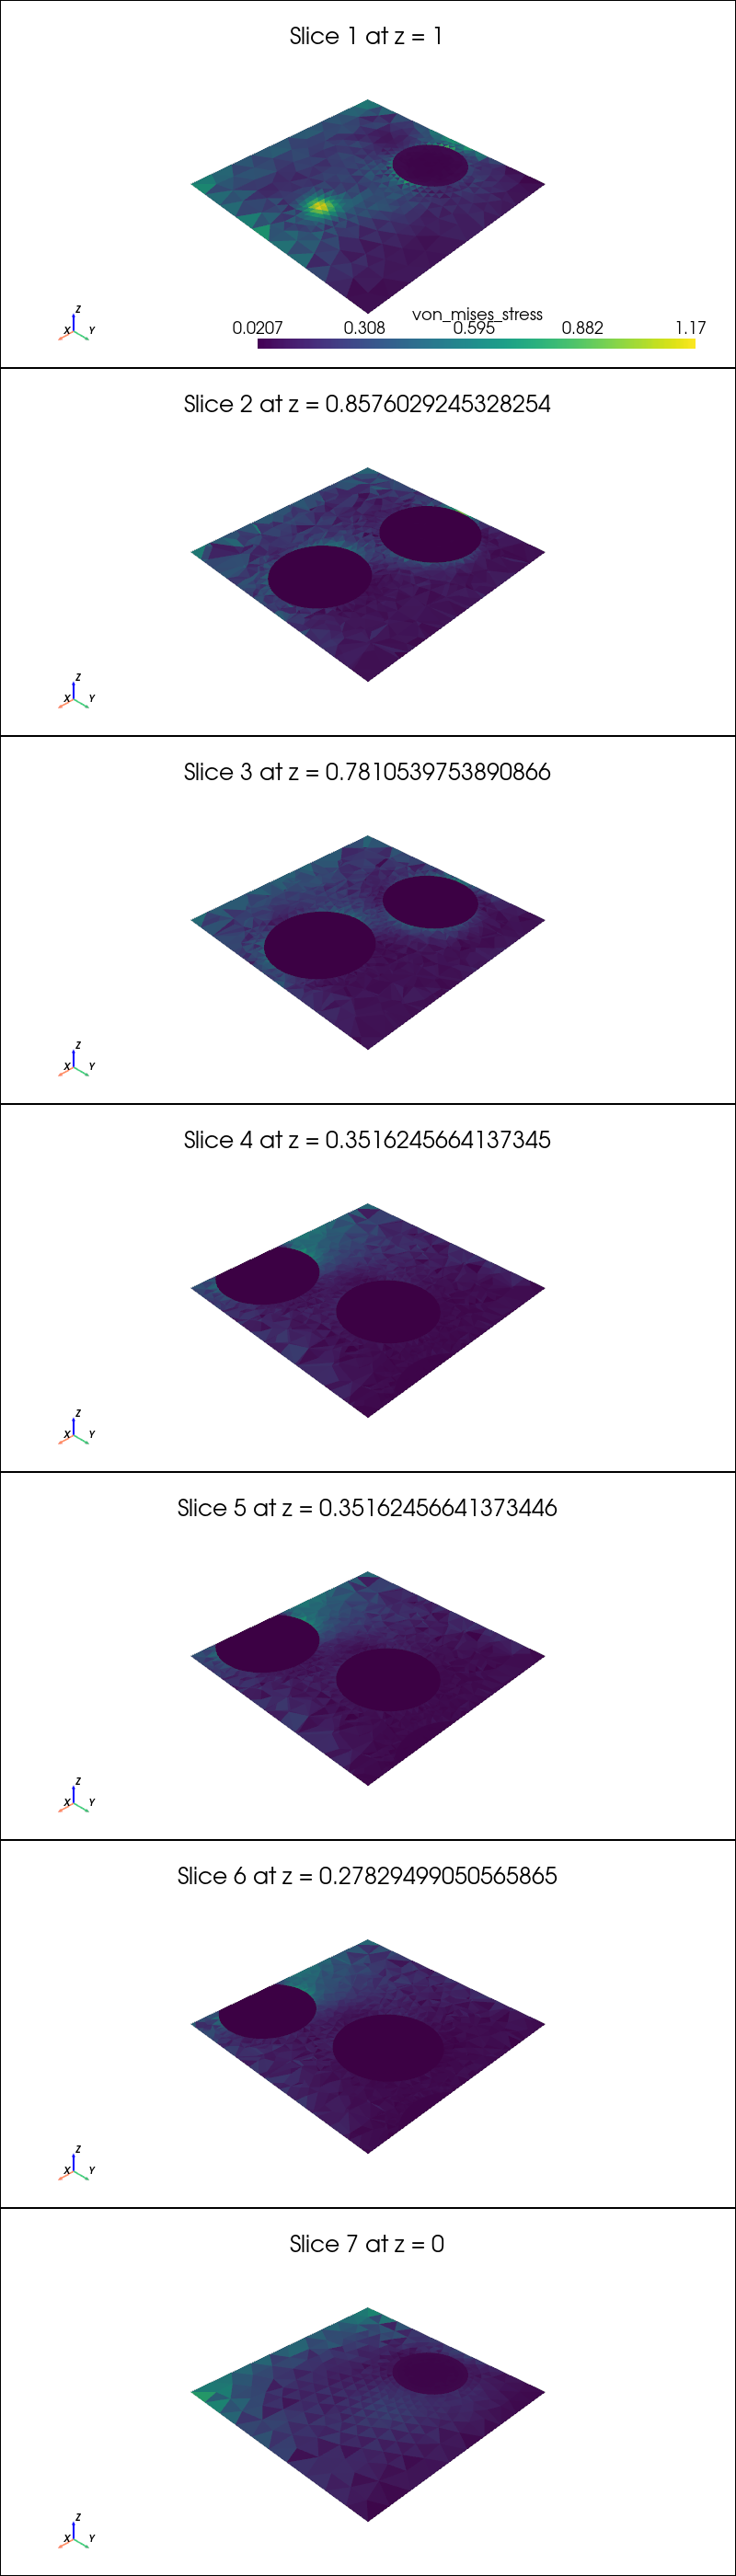

In [17]:
# Postprocessing: Calculate von Mises stress
sigma_dev = sigma(uh) - (1 / 3) * ufl.tr(sigma(uh)) * ufl.Identity(len(uh))
sigma_vm = ufl.sqrt((3 / 2) * ufl.inner(sigma_dev, sigma_dev))

W = functionspace(mesh, ("Discontinuous Lagrange", 0))
sigma_vm_expr = Expression(sigma_vm, W.element.interpolation_points())
sigma_vm_h = Function(W)
sigma_vm_h.interpolate(sigma_vm_expr)

# Save solution to XDMF format
with XDMFFile(mesh.comm, "out_elasticity/displacements.xdmf", "w") as file:
    file.write_mesh(mesh)
    file.write_function(uh)

# Save von Mises stress to XDMF format
with XDMFFile(mesh.comm, "out_elasticity/von_mises_stress.xdmf", "w") as file:
    file.write_mesh(mesh)
    file.write_function(sigma_vm_h)

# Visualization using PyVista
pyvista.start_xvfb()

# Create a plotter with the number of subplots matching the number of particles
ParticleDatas = particles
particles.sort(key=lambda x: x[0][2], reverse=True)

outOfBounds = []
for center,radius in particles:
    if float(center[2])>1 or float(center[2])<0:
        outOfBounds.append(particles.index((center,radius)))
num_slices = len(particles) - len(outOfBounds)+2
p = pyvista.Plotter(shape=(num_slices, 1), window_size=[800, 400 * num_slices])
topology, cell_types, geometry = plot.vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Load the von Mises stress values
sigma_vm_values = sigma_vm_h.x.array

# Attach von Mises stress values to the grid
grid["von_mises_stress"] = sigma_vm_values

p.subplot(0, 0)
slice_filter = grid.slice(normal='z', origin=(0,0,1-10**-10))
p.add_mesh(slice_filter, scalars="von_mises_stress", cmap="viridis", show_edges=False, opacity=1)
p.add_title(f'Slice {1} at z = {1}', font_size=10)
p.show_axes()

i=1
# Add each slice to a subplot
for center, radius in particles:
    if not particles.index((center,radius)) in outOfBounds:
        p.subplot(i, 0)
        slice_filter = grid.slice(normal='z', origin=center)
        p.add_mesh(slice_filter, scalars="von_mises_stress", cmap="viridis", show_edges=False, opacity=1)
        z_coord = center[2]
        p.add_title(f'Slice {i+1} at z = {z_coord}', font_size=10)
        p.show_axes()
        i+=1

p.subplot(num_slices-1, 0)
slice_filter = grid.slice(normal='z', origin=(0,0,10**-10))
p.add_mesh(slice_filter, scalars="von_mises_stress", cmap="viridis", show_edges=False, opacity=1)
p.add_title(f'Slice {num_slices} at z = {0}', font_size=10)
p.show_axes()

# Show the plot with all slices in subplots
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("von_mises_stress_slices.png")